In [80]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import os.path
import abc
import csv
import pandas
import time
from itertools import zip_longest
from matplotlib.lines import Line2D

$r(x)=q(x)+p(x)$  
$r(x)=\frac{1}{N} \sum\limits_{i=1}^{N} f_i(x)= \frac{1}{M}\sum\limits_{j=1}^{M} f_j(x)+\frac{1}{N}\sum\limits_{i=1}^{N} [f_i(x)- \frac{1}{M} \sum\limits_{j=1}^M f_j(x)]$

$q(x)=\frac{1}{M}\sum\limits_{j=1}^{M} f_j(x),\;\;\; p(x)=\frac{1}{N}\sum\limits_{i=1}^{N} [f_i(x)- \frac{1}{M} \sum\limits_{j=1}^M f_j(x)]$


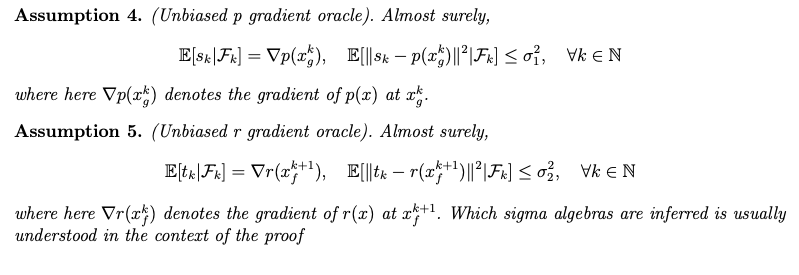

# Классы для функций

## Интерфейс для функций

In [81]:
class IFunction(abc.ABC):
    @abc.abstractmethod
    def getGrad(self,x):
        "gradient is gradient"

    @abc.abstractmethod
    def getValue(self,x):
        "value is value"

    @abc.abstractmethod
    def getArgumentDim(self):
        "return len of argument"

    @abc.abstractmethod
    def getL(self):
        """getting L"""


In [82]:
class IElementaryFunction(abc.ABC): #Интерфейс взаимодействия с функциями, которые создаются по матрице и вектору
    @abc.abstractmethod
    def __init__(self, designMatrixChunk, targetVectorChunk, regCoef):
        """some initialisation"""
    def getMu(self):
        """getting Mu"""

## Класс квадратичной функции

In [83]:
class quadFunction(IElementaryFunction, IFunction):
    def __init__(self, designMatrixChunk, targetVectorChunk, regCoef = 1/100):
        self.batchSize = len(targetVectorChunk)
        self.A      = 2*np.dot( designMatrixChunk.T, designMatrixChunk)/self.batchSize
        self.vector = 2*np.dot( targetVectorChunk.T, designMatrixChunk)/self.batchSize

        self.L = np.linalg.norm(self.A)
        self.mu = 2*self.L*regCoef
        self.regCoef = self.L*regCoef
        self.vec_dim = len(self.vector)


    def getGrad(self, x):
        return (np.matmul(self.A,x) - self.vector)+2*self.regCoef*x

    def getValue(self, x):
        return (0.5*np.matmul(x.T,np.matmul(self.A,x))-np.matmul(self.vector,x))+self.regCoef*np.matmul(x.T,x)

    def getArgumentDim(self):
        return self.vec_dim

    def getL(self):
        return self.L

    def getMu(self):
        return self.mu

    def getMatrix(self):
        return self.A

## Класс логлосс функции

$$\mathcal{L} = \frac{1}{n}\sum_{i=1}^n \ln(1+e^{-y_i \left< w, x_i \right>})$$

$$\nabla \mathcal{L} = - \frac{1}{n} \sum_{i=1}^n \sigma(-y_i \left<w,x_i \right>)x_iy_i $$

$$\nabla^2 \mathcal{L} = \frac{1}{n} \sum_{i=1}^n x_i \otimes x_i^T * \frac{e^{-y_i \left< w, x_i \right>}}{(1+e^{-y_i \left< w, x_i \right>})^2}$$

$$L \leq \frac{1}{4n} \sum_{i=1}^n x_i x_i^T$$

In [84]:
def sigma(x):
  return 1/(1+np.exp(-x))

def exp_frac(x):
  return np.exp(x)/(1+np.exp(x))**2

class loglossFunction(IElementaryFunction, IFunction):
    def __init__(self, designMatrixChunk, targetVectorChunk, regCoef = 0):
        self.summSize = len(targetVectorChunk) # Число слагаемых в батче
        self.vec_dim = np.shape(designMatrixChunk)[-1]
        
        #calculating L
        summ=0
        for row in designMatrixChunk:
            summ+=np.dot(row.T,row)
        self.L = summ/(4*self.summSize)
        
        self.regCoef = self.L*regCoef
        self.X = designMatrixChunk
        self.y = targetVectorChunk
        self.mu = 2*self.regCoef

    def getGrad(self, w):
        vec_tmp = sigma(-self.y*(self.X@w.T))*self.y
        return (-np.sum(self.X * vec_tmp[:, np.newaxis], axis = 0)/self.summSize+2*self.regCoef*w)

    def getValue(self, w):
        return np.sum(np.log(1+np.exp(-self.y*(self.X@w.T))))/self.summSize+self.regCoef*np.matmul(w.T,w)

    def getArgumentDim(self):
        return self.vec_dim

    def getL(self):
        return self.L

    def getMu(self):
        return self.mu

    def getHess(self, w):
        summ = 0
        for i in range(self.summSize):
            summ += np.outer(self.X[i], self.X[i])*exp_frac(-self.y[i]*(self.X[i]@w.T))/self.summSize+2*self.regCoef
        return summ

## Класс суммы функций

In [85]:
class IGradientByIndex(abc.ABC): #Интерфейс взаимодействия с объектами, у которых можно взять градиент по индексу и посчитать общее число слагаемых внутри. Такой интерфейс нужен для работы SARAH, SVRG, SGD
    @abc.abstractmethod
    def getGradByIndex(self, i, x):
        "gradient by x and index"

    def getSumSize(self):
        "size of summ"

In [86]:
class FunctionSum(IFunction, IGradientByIndex):

    def __init__(self, functionsList):
        assert (isinstance(functionsList[0], IFunction))
        self.functionsList = functionsList
        self.L = 0
        for i in range(len(self.functionsList)):
            self.L += functionsList[i].getL()
        self.L = self.L/len(functionsList)

    def getGradByIndex(self, i, x):
        return self.functionsList[i].getGrad(x)
    
    def getGrad(self, x):
        getGrad_np = np.vectorize(lambda f: f.getGrad(x), signature='()->(n)')
        grad_values = getGrad_np(self.functionsList)
        return np.mean(grad_values, axis=0)

    def getValue(self, x):
        sum = 0
        for i in range(len(self.functionsList)):#how to do it faster?
            sum += self.functionsList[i].getValue(x)/len(self.functionsList)
        return sum

    def getArgumentDim(self):
        return self.functionsList[0].getArgumentDim()

    def getSumSize(self):
        return len(self.functionsList)

    def getL(self):
        return self.L

## Класс функции, которую нужно минимизировать в подзадаче

In [87]:
class subtaskFunction(IFunction, IGradientByIndex):
    def __init__(self, s_k, x_kg, theta, q, L):
        assert(isinstance(q, IFunction ))
        assert(isinstance(q, IGradientByIndex))

        self.s_k   = s_k
        self.x_kg  = x_kg
        self.theta = theta
        self.q = q
        self.L = L

    def getGradByIndex(self, i, x):
        return self.s_k + (x - self.x_kg)/self.theta + self.q.getGradByIndex(i,x)

    def getL(self):
        return self.L

    def getGrad(self, x):
        return self.s_k + (x - self.x_kg)/self.theta + self.q.getGrad(x)

    def getValue(self, x):
        assert(1==0) #it is not possible to take value from this function
        pass

    def getArgumentDim(self):
        return self.q.getArgumentDim()

    def getSumSize(self):
        return self.q.getSumSize()

### Реализация интерфейса для оракулов и простейших оракулов

In [88]:
class IRandomOracle(abc.ABC):
    @abc.abstractmethod
    def getRandomVectorCoefficients(vectorSize):
        "random vector"

In [89]:
class UniformRandomOracle(IRandomOracle):
    def __init__(self, center, percent):
        self.center  = center
        self.percent = percent

#Эта функция нужна для работы рандомного шевеления градиента на процент - один из стох. оракулов
#Возвращает равномерное распределение в центре +- percent/100*center. т.е. если center = 1, percent= 10, то
#промежуток случайных значений будет равномерно 0.9 до 1.1
    def getRandomVectorCoefficients(self, vectorSize):
        return (np.random.sample(vectorSize)-0.5)*(self.percent/100*self.center/0.5)+self.center

In [90]:
class DetermenisticOracle(IRandomOracle): #Возвращает вектор из единиц, если мы не хотим учитывать стохастику в p
    def getRandomVectorCoefficients(self, vectorSize):
        return np.ones(vectorSize)

## Чтение функций из датасета

In [91]:
class IDatasetReader(abc.ABC): #Общий интерфейс для разных читалов
    @abc.abstractmethod
    def getDesignMatrix(self):
        """should return X"""

    @abc.abstractmethod
    def getTargets(self):
        """should return y"""

    @abc.abstractmethod
    def getSamplesNumber(self):
        """should return number of samples"""

    @abc.abstractmethod
    def getFeaturesNumber(self):
        """should return number of features"""

In [92]:
class DatasetReaderLocalTxt(IDatasetReader): #Читалка из txt
    def __init__(self, datasetName):
        self.datasetName = datasetName
        self.data = load_svmlight_file(datasetName)

    def getDesignMatrix(self):
        return self.data[0].toarray()

    def getTargets(self):
        return self.data[1]

    def getSamplesNumber(self):
        return len(self.data[1])

    def getFeaturesNumber(self):
        return np.shape(self.data[0])[1]

In [93]:
def getFunctions(datasetReader, functionsNum, functionsType, regCoef=1/100):

    assert(isinstance(datasetReader, IDatasetReader))
    assert(issubclass(functionsType, IFunction))
    assert(issubclass(functionsType, IElementaryFunction))

    designMatrix = datasetReader.getDesignMatrix()
    targets      = datasetReader.getTargets()

    targets = targets - 1.5
    targets = 2*targets
    
    samplesNum   = datasetReader.getSamplesNumber()

    batchSize = math.floor(np.shape(designMatrix)[0]/functionsNum)
    print("batch size = {}".format(batchSize))

    functions = []

    for i in range(functionsNum):
        designMatrixChunk = designMatrix[batchSize*i : batchSize*(i+1)]
        targetsChunk      =      targets[batchSize*i : batchSize*(i+1)]

        functions.append(functionsType(designMatrixChunk, targetsChunk, regCoef))

    print("list of {} functions created with type {}, batch size {} and regCoef coefficient = {}".format(functionsNum, functionsType, batchSize, regCoef))

    return functions

## Обертка pqr

### Получение констант $L_p, L_q$ из массива функций

Будем искать $L_p$ из similarity как
$$|| \nabla^2 f(x) -  \nabla^2 q(x) || \leq L_p$$

In [94]:
class IConvexConstantCreator(abc.ABC):
    @abc.abstractmethod
    def getConvexConstants(self, functions, qSummSize):
        """should return [mu, Lp, Lq]"""

#### Получение констант для квадратичных функций
Зная, что гессиан для линейной функции это есть основная матрица, то можно записать
$$ L_p = \left|\left| \frac{1}{M}\sum_{i=1}^M A_i - \frac{1}{N}\sum_{j=1}^N A_j \right|\right| $$

$L_q = L$, где $L$ - константа выпуклости для всех $f_i(x)$

In [95]:
class quadraticFunctionConstantCreator(IConvexConstantCreator):
    def getConvexConstants(self, functions, qSummSize):
        assert(isinstance(functions[0], quadFunction))

        Llist = []
        num = len(functions)
        muSum = 0

        for func in functions:
            Llist.append(func.getL())
            muSum += func.getMu()

        mu = muSum / num
        L = max(Llist)

        #Ищем Матрицу Гесса для r(x) :
        r_hess = functions[0].getMatrix()
        for j in range(1, num):
            r_hess = r_hess + functions[j].getMatrix()
        r_hess = r_hess / num

        #Ищем Матрицу Гесса для q(x) :
        q_hess = functions[0].getMatrix()
        for i in range(0, qSummSize):
            q_hess = q_hess + functions[i].getMatrix()
        q_hess = q_hess / qSummSize

        Lp = np.linalg.norm(q_hess - r_hess)
        Lq = L

        print( " convex constants : Lp = {}, Lq = {}".format(Lp,Lq))

        return mu, Lp, Lq

#### Получение констант для функций логлосса

$$\nabla^2 q(w) = \frac{1}{M} \sum_{i=1}^M \frac{1}{K} \sum_{j=1}^K \bar{x}(i)_j \otimes \bar{x}(i)_j^T z(w)$$

$$\nabla^2 r(w) = \frac{1}{N} \sum_{i=1}^N \frac{1}{K} \sum_{j=1}^K \bar{x}(i)_j \otimes \bar{x}(i)_j^T z(w)$$

$$ z = \frac{e^{y(i)_j \left<w,x(i)_j \right>}}{1+ e^{y(i)_j \left<w,x(i)_j \right>}} $$

Никаких хороших результатов здесь не получается, поэтому будем искать оценку константы выпуклости через семплирование
1. Генерируется S точек $w_i, i\in [1,100]$ в некоторой области (желательно близко к минимуму)
2. В них меряем $\delta(w_i) = || \nabla^2 q(w_i) - \nabla^2 r(w_i) ||$
3. В качестве $L_p$ берем $\max_{i\in[1,S]} ||\delta(w_i)||$

In [96]:
def generateSample(vectorSize, sampleSize, radius):
  pointsList = []
  for i in range(sampleSize):
    pointsList.append(np.random.uniform(- radius, radius, vectorSize))

  return pointsList

In [97]:
def getLogregLp(functions, qSummSize, sampleSize, searchRadius):
    deltaList = []
    sample = generateSample(vectorSize = functions[0].getArgumentDim(), sampleSize = sampleSize, radius = searchRadius )

    for i in range(sampleSize):
    #1.calculating \nabla^2 q(w_i)
        hess_q = 0
        for j in range(qSummSize):
            hess_q += functions[j].getHess(sample[i])
        hess_q = hess_q / qSummSize

        
    #1.calcaulating \nabla^2 r(w_i)
        hess_r = hess_q * qSummSize; #getting first terms from hess_q
        for j in range(qSummSize, len(functions)):
            hess_r += functions[j].getHess(sample[i])
        hess_r = hess_r/len(functions);
        
        deltaList.append(np.linalg.norm(hess_q - hess_r))

    return max(deltaList)

In [98]:
class loglossFunctionConstantCreator(IConvexConstantCreator): #Здесь реализован вариант с забиранием константы из файлов, потому что прямое их вычисление  может занять много времени.
    def __init__(self, readMode = True, fileName = ""): #в fileName лучше указывать и число функций с qSummSize 
        file = "convexConstants/"+fileName
        self.readMode = readMode
        self.file = file
        if(readMode):
            assert(os.path.exists(file)) #there is no file with this name
            openFile = open(file)
            self.Lp = float(openFile.read())
        
            
    def getConvexConstants(self, functions, qSummSize):
        functionsNum = len(functions)
        mu_sum = 0
        #Ищем общую константу выпуклости для всех $f_i(x)$
        Llist = []
        for i in range(functionsNum):
            Llist.append(functions[i].getL())
            mu_sum+=functions[i].getMu()
        mu=mu_sum/functionsNum
        Lq = max(Llist)        
        if(self.readMode):
            Lp = self.Lp
        else:
            Lp = 2*getLogregLp(functions, qSummSize, sampleSize = 100, searchRadius = -3) #см. logloss similarity тесты и выводы. На новом датасете pars нужно будет поменять
            openFile = open(self.file, "w+")
            openFile.write(str(Lp))
            openFile.close()
        print( " convex constants : mu = {}, Lp = {}, Lq = {}".format(mu,Lp,Lq))

        return mu, Lp, Lq

#### Обертка для функций p,q,r

In [99]:
class rqFunctionsWrapper:
    def __init__(self, functions, qSummSize, randomOracle, convexConstantCreator): # Внутри лежат только функции q,r; функция p вычисляется на месте как их разность и затем результат домножается на вектор из randomOracle
        self.r = FunctionSum(functions)
        self.q = FunctionSum(functions[:qSummSize])
        convexConstants = convexConstantCreator.getConvexConstants(functions = functions, qSummSize = qSummSize)
        self.randomOracle = randomOracle #random oracle for p = r - q function
        self.mu = convexConstants[0]
        self.Lp = convexConstants[1]
        self.Lq = convexConstants[2]

# Код для решения задачи

## Шаги

In [100]:
class IStepFunction(abc.ABC): #Интерфейс для функци шага
    @abc.abstractmethod
    def getStep(self, L, i):
        "making step"

In [101]:
class classicStep(IStepFunction):
    def getStep(self, L, i):
        return 1/L/2

class smallClassicStep(IStepFunction):
    def getStep(self, L, i):
        return 1/L/200

class invStep(IStepFunction):
    def getStep(self, L, i):
        return 1/L/i

class smallInvStep(IStepFunction):
    def getStep(self, L, i):
        return 1/L/i/10

class smartVariableStep(IStepFunction):
    def getStep(self, L, i):
        return 2/L/np.sqrt(i)

class minBalancedStep(IStepFunction):
    def getStep(self, L, i):
        return min(1/L/2, 1/np.sqrt(i)/10)

class bigVariableStep(IStepFunction):
    def getStep(self, L, i):
        return 1/10/(L+10*np.sqrt(i))

class smallIncreasingVarStep(IStepFunction):
    def getStep(self, L, i):
        return 1/(L+np.sqrt(it_num))

## Способ вернуть точку из подзадачи

В зависимости от значения argmin_mod меняется возвращаемая точка.
- "last" - возвращается последняя точка
- "mean" - возвращает среднее по всем точкам
- "mean_10" - возвращает среднее по последним 10 точкам
- "min" - возвращает точку, в которой $||\nabla A||$ достигает минимума

In [102]:
class IReturnPointManager(abc.ABC): #Осторожно - все варианты которые используют logs требуют, чтобы logs был непустой - а заполнение логов в подзадаче это очень дорогое удовольствие и замедляет работу программы в 15 раз
    @abc.abstractmethod
    def getPoint(xes, logs):
        "calculate some point"

In [103]:
class LastPointMod(IReturnPointManager):
    def getPoint(self, xes, logs):
        return xes[-1]

class Mean10PointMod(IReturnPointManager):
    def getPoint(self, xes, logs):
        return np.mean(xes[-10:], axis = 0)

class MeanPointMod(IReturnPointManager):
    def getPoint(self, xes, logs):
        return mp.mean(xes, axis = 0)

class MinPointMod(IReturnPointManager):
    def getPoint(self, xes, logs):
        return xes[np.argmin(logs)]

# Солверы

In [104]:
class ISolver(abc.ABC):
    def __init__(self, iterations, step, returnMod, collectLogs = False):
        assert(isinstance(step, IStepFunction))
        assert(isinstance(returnMod, IReturnPointManager))

        self.iterations = iterations
        self.step = step
        self.returnMod = returnMod
        self.collectLogs = collectLogs

        self.gradLogs = []


    @abc.abstractmethod
    def solve(self, function):
        """solving"""

    def getLog(self):
        return self.gradLogs
        
    def clearLog(self):
        self.gradLogs = []

In [105]:
class SGDSolver(ISolver):

    def solve(self, function):
        assert(isinstance(function, IFunction))
        assert(isinstance(function, IGradientByIndex))
        sumSize = function.getSumSize()
        pointsLog = []

        x = np.zeros(function.getArgumentDim())

        for i in range(1, self.iterations):
            g = function.getGradByIndex(i%sumSize, x)
            x = x - self.step.getStep(function.getL(), i)*g
            pointsLog.append(x)

            if(self.collectLogs):
                self.gradLogs.append(np.linalg.norm(function.getGrad(x))**2)

        return self.returnMod.getPoint(pointsLog, self.collectLogs)

In [106]:
class SARAHSolver(ISolver):
    def __init__(self, iterations, step, refreshRate, returnMod, collectLogs = False):

        assert(isinstance(step, IStepFunction))
        assert(isinstance(returnMod, IReturnPointManager))

        self.iterations = iterations
        self.step = step
        self.refreshRate = refreshRate
        self.returnMod = returnMod
        self.collectLogs = collectLogs

        self.gradLogs = []

    def solve(self, function):
        assert(isinstance(function, IFunction))
        assert(isinstance(function, IGradientByIndex))
        
        sumSize = function.getSumSize()
        x = np.zeros(function.getArgumentDim())
        pointsLog = [x]
        lastPoint = np.copy(x)
        g = np.copy(x)

        refreshCounter = self.refreshRate
        for i in range(1, self.iterations):
            if(refreshCounter == self.refreshRate):
                refreshCounter = 0
                g = function.getGrad(x)
            else:
                g += function.getGradByIndex(i%sumSize, x) - function.getGradByIndex(i%sumSize, pointsLog[-2])
                
            x = x - self.step.getStep(function.getL(), i)*g
            pointsLog.append(x)
            refreshCounter += 1

            if(self.collectLogs):
                self.gradLogs.append(np.linalg.norm(function.getGrad(x),2)**2)
                
        return self.returnMod.getPoint(pointsLog, self.collectLogs)


In [107]:
class SVRGSolver(ISolver):
    def __init__(self, iterations, step, refreshRate, returnMod, collectLogs = False):
        assert(isinstance(step, IStepFunction))
        assert(isinstance(returnMod, IReturnPointManager))

        self.iterations = iterations
        self.step = step
        self.refreshRate = refreshRate
        self.returnMod = returnMod
        self.collectLogs = collectLogs

        self.gradLogs = []

    def solve(self, function):
        assert(isinstance(function, IFunction))
        assert(isinstance(function, IGradientByIndex))
        
        sumSize = function.getSumSize()

        x = np.zeros(function.getArgumentDim())
        pointsLog = [x]
        lastPoint = np.copy(x)
        g = np.copy(x)
        refresh_counter = self.refreshRate
        for i in range(1, self.iterations):
            if(refresh_counter == self.refreshRate):
                refresh_counter = 0
                w=x
                gradAw = function.getGrad(x)
            refresh_counter+=1
            g = function.getGradByIndex(i%sumSize, x) - function.getGradByIndex(i%sumSize, w) + gradAw
            x = x - self.step.getStep(function.getL(), i)*g
            pointsLog.append(x)
            if(self.collectLogs):
                self.gradLogs.append(np.linalg.norm(function.getGrad(x))**2)

        return self.returnMod.getPoint(pointsLog, self.collectLogs)


# Класс Accelerated Extragradient

Чтобы инициализировать класс, ему нужно передать PQR - обертку над набором самих функций p,q,r, их честными и стох градиентами, а так же константами выпуклости этих функций

In [108]:
class Accelerated_Extragradient:
    
    def __init__(self, pqr, outerIterations, pRandomOracle, logsGap = 1):
        assert(isinstance(pqr, rqFunctionsWrapper))
        assert(isinstance(pRandomOracle, IRandomOracle))
        self.Lq = pqr.Lq
        self.Lp = pqr.Lp
        self.mu = pqr.mu
        self.outerIterations = outerIterations

        self.r = pqr.r
        self.q = pqr.q

        #Параметры для работы алгоритма
        self.tau=min(1,math.sqrt(self.mu)/(2*math.sqrt(self.Lp)))
        self.theta=1/(2*self.Lp)
        self.eta=min(1/(2*self.mu),1/(2*math.sqrt(self.mu*self.Lp)))
        self.alpha=self.mu

        self.pRandomOracle = pRandomOracle
        self.logsGap = logsGap


    def solve(self, solver):
        assert(isinstance(solver, ISolver)) #solver is not inherited from ISolver interface 
        tau=self.tau
        theta=self.theta
        eta=self.eta
        alpha=self.alpha

        x_start = np.zeros(self.r.getArgumentDim())
        x_kf = x_start
        x_k = x_start
        x_kg = x_start
        #tmpstep = lambda i : step(i, self.Lq + 1/self.theta) #Прячем константу выпуклости под ковер лямбда выражения
        norms_log = []

        for k in range(self.outerIterations):
            if(k%20 == 0):
              print("{} ASEG iterations complete".format(k))
            #Считаем взвешенную сумму
            x_kg=tau*x_k+(1-tau)*x_kf

            #Создаем подзадачу
            s_k = (self.r.getGrad(x_kg)-self.q.getGrad(x_kg))*self.pRandomOracle.getRandomVectorCoefficients(len(x_start))
            subtaskFunc = subtaskFunction(s_k = s_k, theta = theta, x_kg = x_kg, q = self.q, L = self.Lq + 1/self.theta)
            
            #Решаем подзадачу
            x_kf = solver.solve(subtaskFunc) 

            #Итерация в основной задаче
            x_k = x_k + eta*alpha*(x_kf-x_k)-eta*self.r.getGrad(x_kf)

            if(k%self.logsGap == 0):
              norms_log.append(np.linalg.norm(self.r.getGrad(x_k),2)**2)

        return norms_log

    def subtaskSolve(self, solver):
        assert(isinstance(solver, ISolver)) #solver is not inherited from ISolver interface 
        tau=self.tau
        theta=self.theta
        eta=self.eta
        alpha=self.alpha

        x_start = np.zeros(self.r.getArgumentDim())
        x_kf = x_start
        x_k = x_start
        x_kg = x_start

        for k in range(self.outerIterations):
            if(k%100 == 0):
              print("{} ASEG iterations complete".format(k))
            
            #Считаем взвешенную сумму
            x_kg=tau*x_k+(1-tau)*x_kf

            #Создаем подзадачу
            s_k = (self.r.getGrad(x_kg)-self.q.getGrad(x_kg))*self.pRandomOracle.getRandomVectorCoefficients(len(x_start))
            subtaskFunc = subtaskFunction(s_k = s_k, theta = theta, x_kg = x_kg, q = self.q, L = self.Lq + 1/self.theta)
            
            #Решаем подзадачу
            x_kf = solver.solve(subtaskFunc)

            #Итерация в основной задаче
            x_k = x_k + eta*alpha*(x_kf-x_k)-eta*self.r.getGrad(x_kf)
            
            #Чистим ненужные логи солвера подзадачи
            solver.clearLog()

        
        # Затеем делаем еще одну итерацию подзадачи и возвращаем оттуда логи
        solver.collectLogs = True #а то не ловко будет
        x_kg=tau*x_k+(1-tau)*x_kf
        #Создаем подзадачу
        s_k = (self.r.getGrad(x_kg)-self.q.getGrad(x_kg))*self.pRandomOracle.getRandomVectorCoefficients(len(x_start))
        subtaskFunc = subtaskFunction(s_k = s_k, theta = theta, x_kg = x_kg, q = self.q, L = self.Lq + 1/self.theta)
        x_kf = solver.solve(subtaskFunc)
        return solver.getLog()

# Обработка логов


## CSV Менеджер

In [109]:
class CSVManager():
    def __init__(self, fileName, directory = "experiments"):
        self.fileName = fileName
        self.directory = directory

    def saveToCSV(self, names, data):
        df = pandas.DataFrame(data)
        df = df.transpose()
        df.columns = names
        df.to_csv(self.directory + "/" + self.fileName, index=False)  
        
    def getLogsFromCSV(self):
        data = pandas.read_csv(self.directory + "/" + self.fileName)
        names = list(data)
        dataLists=[]

        for name in names:
            dataLists.append(data[name].tolist())

        return names, dataLists

    def addToCSV(self, names, data):
        readNames, readDataLists = self.getLogsFromCSV()
        
        readDataLists = readDataLists + data
        readNames = readNames + names
        
        self.saveToCSV(readNames, readDataLists)

## Плоттер

In [110]:
class ThreePlotter():
    def __init__(self, legendNames, listOfListsOfLogs):
        assert(len(listOfListsOfLogs) == 3)
        self.legendNames = legendNames
        self.listOfListsOfLogs = listOfListsOfLogs
        
    def plot(self, stepLimiter = -1):
        # making subplots
        fig, ax = plt.subplots(1, 3, figsize = (18,6))
        # set data with subplots and plot
        for k in range(len(self.listOfListsOfLogs)):
            for j in range(len(self.listOfListsOfLogs[k])):
                ax[k].plot(self.listOfListsOfLogs[k][j][:stepLimiter], label = self.legendNames[j])
                ax[k].grid()
                ax[k].set_yscale("log")

        ax[2].legend(loc="upper right", fontsize="20")
        plt.show()

In [111]:
class SixPlotter():
    def __init__(self, legendNames, listOfListsOfLogs, graphType = 'refresh'):
        assert(len(listOfListsOfLogs) == 6)
        self.legendNames = legendNames
        self.listOfListsOfLogs = listOfListsOfLogs
        if (graphType == 'refresh'):
            self.markersMap = {'50':'P', '100':'X', '200':'^', '500':'v'}
            self.colorsMap = {'50':'blue', '100':'orange', '200':'seagreen', '500':'red'}
        elif (graphType == 'stability'):
            self.markersMap = {'percent = 1':'P', 'percent = 3':'X', 'percent = 5':'^', 'percent = 10':'v'}
            self.colorsMap = {'percent = 1':'blue', 'percent = 3':'orange', 'percent = 5':'seagreen', 'percent = 10':'red'}
        else:
            assert(1==0) #there is no such graph type
        
        
    def plot(self, stepLimiter = [-1, -1, -1, -1, -1, -1], legendWord = "refresh rate = {}", markersSteps = [100, 100, 100, 100, 100, 100]):
        datasetsNames=["quadratic Mushrooms", "quadratic W8A", " quadratic A9A", "logloss Mushrooms", "logloss W8A", "logloss A9A"]
        #deleting extra pairs

        markersMap = self.markersMap
        colorsMap  = self.colorsMap
        
        flatLegendNames = [item for sublist in self.legendNames for item in sublist]
        markersMap = {key: value for key, value in markersMap.items() if key in flatLegendNames}
        colorsMap = {key: value for key, value in colorsMap.items() if key in flatLegendNames}
        
        fig, ax = plt.subplots(2, 3, figsize = (18,12))
        plt.rcParams.update({'font.size': 19})
        fig.tight_layout()
        for k in range(len(self.listOfListsOfLogs)):
            for j in range(len(self.listOfListsOfLogs[k])):
                x = k%3
                y = k//3
                dataName = self.legendNames[k][j]
                currentData = self.listOfListsOfLogs[k][j][:stepLimiter[k]]
                
                #plotting data line :
                ax[y][x].plot(currentData, color = colorsMap[dataName], linewidth = 2, zorder = 1)
                ax[y][x].set_title(datasetsNames[k] , fontweight='bold', fontsize= 19)
                ax[y][x].grid()
                ax[y][x].set_yscale("log")
                
                #markers :
                markerStep = markersSteps[k]
                marker_indices = range(0, len(currentData), markerStep)
                ax[y][x].scatter(np.arange(0, len(currentData), markerStep), currentData[::markerStep], s = 400, marker = markersMap[dataName], color = colorsMap[dataName], zorder = 2, alpha = 0.8)
        
        fig.text(-0.05, 0.5, r'$||\nabla f(x)||^2$', va='center', rotation='vertical', fontsize = 30)
        fig.text(0.5, -0.05, 'Iteration number', ha='center', fontsize = 30  )

        LegendLinesAndMarkers=[]
        markers=[]
        for name in colorsMap.keys():
            line = Line2D([0], [0], color = colorsMap[name], lw = 10)
            marker = Line2D([0], [0], marker=markersMap[name], markerfacecolor=colorsMap[name], markersize=20)
            markers.append(marker)
            LegendLinesAndMarkers.append((line, marker))
            

        legendNames = []
        for key in colorsMap.keys():
            legendNames.append(legendWord.format(key))
            
        for i in range(len(legendNames)):
            # fig.legend(LegendLinesAndMarkers, legendNames)
            fig.legend(LegendLinesAndMarkers, legendNames, handlelength = 2, bbox_to_anchor = (1.0, 0.95))
        plt.show()

In [112]:
np.arange(0, 360, 100)

array([  0, 100, 200, 300])

# Тесты написанного

## Тесты квадратичной функции

In [113]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functionsList = getFunctions(datasetReader, functionsNum = 100, functionsType = quadFunction )
function = functionsList[0]
x = np.ones(function.getArgumentDim())

batch size = 81
list of 100 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01


In [114]:
function.getGrad(x)

array([ 0.57009752, 11.43429506,  6.54540617,  0.57009752,  2.05157901,
       22.98985061, 20.32318394, 15.13799876,  0.57009752,  6.98985061,
        0.57009752,  0.57009752,  0.57009752,  3.53306049,  9.80466543,
        0.57009752,  0.57009752,  0.57009752, 12.8170111 , 16.86639382,
       35.38491234,  6.49602345, 12.42194938,  0.57009752,  0.57009752,
        0.57009752, 15.38491234,  6.49602345,  8.71824567,  0.57009752,
        0.57009752,  0.57009752, 41.31083827, 34.89108518,  6.98985061,
       26.74293703, 15.13799876,  0.57009752,  0.57009752,  5.01454197,
        0.57009752, 12.71824567,  0.57009752, 12.1750358 ,  5.60713456,
        0.57009752,  0.57009752,  8.07627036,  0.57009752, 34.89108518,
        6.98985061,  0.57009752, 40.8170111 ,  0.57009752,  1.06392468,
        5.50836913, 35.8787395 ,  0.57009752,  1.06392468,  0.57009752,
        0.57009752,  0.57009752,  0.57009752,  0.57009752,  0.57009752,
        0.57009752, 41.31083827,  0.57009752,  0.57009752,  0.57

In [115]:
function.getValue(x)

446.4810169215624

In [116]:
function.getArgumentDim()

112

In [117]:
function.getL()

28.504876219649066

In [118]:
function.getMu()

0.5700975243929813

In [119]:
function.getMatrix()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.54320988, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.2962963 , ..., 0.04938272, 0.02469136,
        0.        ],
       ...,
       [0.        , 0.        , 0.04938272, ..., 0.17283951, 0.        ,
        0.        ],
       [0.        , 0.        , 0.02469136, ..., 0.        , 0.39506173,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Тесты логлосс функции

In [120]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functionsList = getFunctions(datasetReader, functionsNum = 100, functionsType = loglossFunction )
function = functionsList[0]
x = np.ones(function.getArgumentDim())

batch size = 81
list of 100 functions created with type <class '__main__.loglossFunction'>, batch size 81 and regCoef coefficient = 0.01


In [121]:
function.getGrad(x)

array([0.105     , 0.105     , 0.11734568, 0.105     , 0.105     ,
       0.27783951, 0.22845679, 0.16672839, 0.105     , 0.105     ,
       0.105     , 0.105     , 0.105     , 0.105     , 0.19141975,
       0.105     , 0.105     , 0.105     , 0.20376543, 0.105     ,
       0.29018518, 0.105     , 0.105     , 0.105     , 0.105     ,
       0.105     , 0.105     , 0.105     , 0.29018519, 0.105     ,
       0.105     , 0.105     , 0.29018518, 0.29018518, 0.105     ,
       0.105     , 0.29018518, 0.105     , 0.105     , 0.105     ,
       0.105     , 0.17907407, 0.105     , 0.16672839, 0.12969136,
       0.105     , 0.105     , 0.12969136, 0.105     , 0.29018518,
       0.105     , 0.105     , 0.29018518, 0.105     , 0.105     ,
       0.105     , 0.29018518, 0.105     , 0.105     , 0.105     ,
       0.105     , 0.105     , 0.105     , 0.105     , 0.105     ,
       0.105     , 0.29018518, 0.105     , 0.105     , 0.105     ,
       0.105     , 0.105     , 0.105     , 0.105     , 0.105  

In [122]:
function.getArgumentDim()

112

In [123]:
function.getL()

5.25

In [124]:
function.getMu()

0.105

## Тесты суммы функций

In [125]:
datasetReader = DatasetReaderLocalTxt("datasets/w8a.txt")
functionsList = getFunctions(datasetReader, functionsNum = 100, functionsType = quadFunction )
x = np.ones(functionsList[0].getArgumentDim())

batch size = 497
list of 100 functions created with type <class '__main__.quadFunction'>, batch size 497 and regCoef coefficient = 0.01


In [126]:
funcSum = FunctionSum(functionsList)

In [127]:
funcSum.getGrad(x)

array([ 1.15575858,  0.95938031,  1.38280083,  0.96300204,  1.30103021,
        1.10098997,  1.48738836,  1.16614087,  1.04573846,  1.68223745,
        1.23785113,  1.35954127,  1.21217709,  1.19507447,  1.23732799,
        1.9679115 ,  0.97342457,  1.33648292,  1.73809258,  1.82030586,
        1.42203624,  1.10086924,  1.43165395,  1.18839439,  1.2991791 ,
        1.45495375,  1.2857787 ,  1.43298192,  1.13523544,  1.04171431,
        1.38936019,  1.55974248,  1.22573846,  1.363163  , 10.09076864,
        0.27475254,  4.41732799,  6.75563785,  0.26372638,  0.16272035,
        0.70010465,  0.17064791,  0.17064791,  3.94243866,  3.9551952 ,
        0.30320325,  4.64505435,  0.28457146,  0.16050707,  3.83105033,
        2.79547689,  0.29016502,  1.57455133,  8.59282095, 10.10284107,
        0.24678473,  9.25169419,  0.16718715,  5.48392759,  0.49261974,
        0.17426964,  4.40726763,  0.35978272,  0.16980284,  0.54171431,
        0.35656341,  0.223163  ,  6.68533604,  6.679662  ,  3.02

In [128]:
funcSum.getValue(x)

402.30058747179896

In [129]:
funcSum.getGradByIndex(5, x)

array([ 0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  0.11427101,
        0.11427101,  0.11427101,  0.11427101,  0.11427101,  6.39998529,
        0.20280219,  4.25511608,  6.9030034 ,  0.11427101,  0.11427101,
        2.40803358,  0.11427101,  0.11427101,  2.46839575,  4.67765129,
        0.11427101,  2.0780537 ,  0.16658489,  0.11427101,  2.22694706,
        1.82050843,  0.11427101,  2.27121266,  7.65954264,  9.9613535 ,
        0.11427101,  8.46437161,  0.11427101,  3.14847624,  0.19072976,
        0.11427101,  2.2390195 ,  0.3114541 ,  0.11427101,  1.29334545,
        0.11427101,  0.11427101,  9.36578006,  5.68771165,  5.49

In [130]:
funcSum.getArgumentDim()

300

In [131]:
funcSum.getSumSize()

100

In [132]:
funcSum.getL()

7.834206554986004

## Тесты шагов

## Тесты pqr обертки

In [133]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functions = getFunctions(datasetReader, functionsNum = 100, functionsType = quadFunction, regCoef=1/100)
funSum = FunctionSum(functions)

batch size = 81
list of 100 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01


In [134]:
pqr = rqFunctionsWrapper(functions, qSummSize = 50, randomOracle = 0, convexConstantCreator = quadraticFunctionConstantCreator())

 convex constants : Lp = 10.150976410427115, Lq = 32.133419090817114


In [135]:
pqr.r

In [136]:
pqr.q

In [137]:
pqr.mu

0.5461991559957915

In [138]:
pqr.Lp

10.150976410427115

In [139]:
pqr.Lq

32.133419090817114

## Тесты солверов

### Прогонка SGD

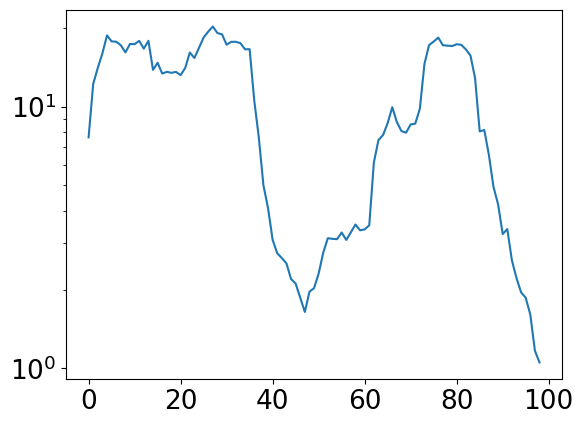

In [140]:
task = SGDSolver(iterations = 100, step = classicStep(), returnMod = LastPointMod(), collectLogs = True)
task.solve(pqr.r)
plt.plot(task.getLog())
plt.yscale("log")

### Прогонка SARAH

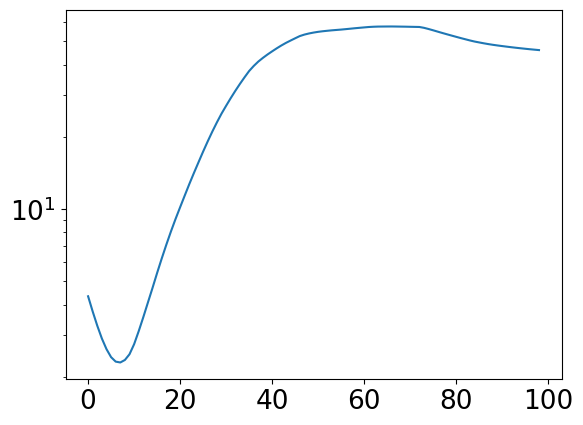

In [141]:
task = SARAHSolver(iterations = 100, step = classicStep(), refreshRate = 100, returnMod = LastPointMod(), collectLogs = True)
task.solve(pqr.r)
plt.plot(task.getLog())
plt.yscale("log")

### Прогонка SVRG

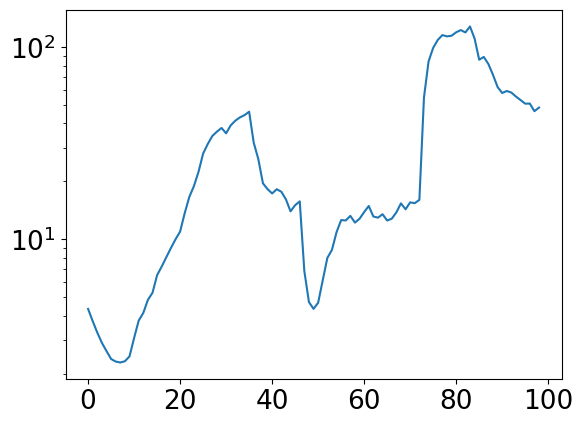

In [142]:
task = SVRGSolver(iterations = 100, step = classicStep(), refreshRate = 100, returnMod = LastPointMod(), collectLogs = True)
task.solve(pqr.r)
plt.plot(task.getLog())
plt.yscale("log")

## Прогонка ASEG

### На квадратичной задаче

In [143]:
noRandom = DetermenisticOracle()

In [144]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functions = getFunctions(datasetReader, functionsNum = 100, functionsType = quadFunction, regCoef=1/100)
funSum = FunctionSum(functions)
randomOracle = DetermenisticOracle()

pqr = rqFunctionsWrapper(functions, qSummSize = 50, randomOracle = DetermenisticOracle, convexConstantCreator = quadraticFunctionConstantCreator())
solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 10, returnMod = Mean10PointMod(), collectLogs = False)

batch size = 81
list of 100 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : Lp = 10.150976410427115, Lq = 32.133419090817114


In [ ]:
task = Accelerated_Extragradient(pqr = pqr, outerIterations = 10, pRandomOracle = noRandom)
logs = task.solve(solver = solver)

0 ASEG iterations complete


In [ ]:
plt.plot(logs)
plt.yscale('log')

# ЭТА ЧАСТЬ КОДА ЗАПОЛНЯЕТ ПАПКУ convexConstants, которая нужна для быстрого создания pqr для задач логлосса. Если папка не пустая, или константы не надо уточнять, то делать эту часть кода не надо !

In [ ]:
datasetReader = DatasetReaderLocalTxt("datasets/a9a.txt")
functions = getFunctions(datasetReader, functionsNum = 400, functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
randomOracle = DetermenisticOracle()
convexConstantCreator = loglossFunctionConstantCreator(readMode = False, fileName = "a9a_400_200.txt")

start = time.time()
pqr = rqFunctionsWrapper(functions, qSummSize = 200 , randomOracle = DetermenisticOracle, convexConstantCreator = convexConstantCreator)
print( (time.time() - start)/60,"mins passed")

In [ ]:
datasetReader = DatasetReaderLocalTxt("datasets/w8a.txt")
functions = getFunctions(datasetReader, functionsNum = 610, functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
randomOracle = DetermenisticOracle()

convexConstantCreator = loglossFunctionConstantCreator(readMode = False, fileName = "w8a_610_305.txt")

start = time.time()
pqr = rqFunctionsWrapper(functions, qSummSize = 305, randomOracle = DetermenisticOracle, convexConstantCreator = convexConstantCreator)
print( (time.time() - start)/60,"mins passed")

In [ ]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functions = getFunctions(datasetReader, functionsNum = 100, functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
randomOracle = DetermenisticOracle()

convexConstantCreator = loglossFunctionConstantCreator(readMode = False, fileName = "mushrooms_100_50.txt")
start = time.time()
pqr = rqFunctionsWrapper(functions, qSummSize = 50, randomOracle = DetermenisticOracle, convexConstantCreator = convexConstantCreator)
print( (time.time() - start)/60,"mins passed")

solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 10, returnMod = Mean10PointMod(), collectLogs = True)

# Подгружаем все pqr для тестов

In [65]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functions = getFunctions(datasetReader, functionsNum = 100 , functionsType = quadFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = quadraticFunctionConstantCreator()

pqrMushrooms = rqFunctionsWrapper(functions, qSummSize = 50, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 100 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : Lp = 10.150976410427115, Lq = 32.133419090817114


In [66]:
datasetReader = DatasetReaderLocalTxt("datasets/mushrooms.txt")
functions = getFunctions(datasetReader, functionsNum = 100 , functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = loglossFunctionConstantCreator(readMode = True, fileName = "mushrooms_100_50.txt")

pqrLoglossMushrooms = rqFunctionsWrapper(functions, qSummSize = 50, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 100 functions created with type <class '__main__.loglossFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : mu = 0.10500000000000025, Lp = 1.452659256939036, Lq = 5.25


In [67]:
datasetReader = DatasetReaderLocalTxt("datasets/w8a.txt")
functions = getFunctions(datasetReader, functionsNum = 610 , functionsType = quadFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = quadraticFunctionConstantCreator()

pqrW8A = rqFunctionsWrapper(functions, qSummSize = 305, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 610 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : Lp = 1.1782079220946367, Lq = 66.38966228291913


In [68]:
datasetReader = DatasetReaderLocalTxt("datasets/w8a.txt")
functions = getFunctions(datasetReader, functionsNum = 610 , functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = loglossFunctionConstantCreator(readMode = True, fileName = "w8a_610_305.txt")

pqrLoglossW8A = rqFunctionsWrapper(functions, qSummSize = 305, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 610 functions created with type <class '__main__.loglossFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : mu = 0.05822576401538151, Lp = 101.83346422624552, Lq = 11.898148148148149


In [69]:
datasetReader = DatasetReaderLocalTxt("datasets/a9a.txt")
functions = getFunctions(datasetReader, functionsNum = 400 , functionsType = quadFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = quadraticFunctionConstantCreator()

pqrA9A = rqFunctionsWrapper(functions, qSummSize = 200, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 400 functions created with type <class '__main__.quadFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : Lp = 0.14920344308609745, Lq = 14.01186163301652


In [70]:
datasetReader = DatasetReaderLocalTxt("datasets/a9a.txt")
functions = getFunctions(datasetReader, functionsNum = 400 , functionsType = loglossFunction, regCoef=1/100)
funSum = FunctionSum(functions)
convexConstantCreator = loglossFunctionConstantCreator(readMode = True, fileName = "a9a_400_200.txt")

pqrLoglossA9A = rqFunctionsWrapper(functions, qSummSize = 200, randomOracle = 0, convexConstantCreator = convexConstantCreator)

batch size = 81
list of 400 functions created with type <class '__main__.loglossFunction'>, batch size 81 and regCoef coefficient = 0.01
 convex constants : mu = 0.06934629629629627, Lp = 0.0605563991039406, Lq = 3.496913580246914


In [71]:
noRandom = DetermenisticOracle()

In [72]:
pqrList = [pqrMushrooms, pqrW8A, pqrA9A, pqrLoglossMushrooms, pqrLoglossW8A, pqrLoglossA9A]

# Тесты SGD

## subtask

In [ ]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SGD/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SGD/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SGD/quadratic")
saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerW8A]

In [ ]:
for i in range(len(pqrList)):
    solver = SGDSolver(iterations = 2000, step = classicStep(), returnMod = LastPointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 10, pRandomOracle = noRandom, logsGap = 10)
    saveManagerList[i].saveToCSV(["uno dato"], [task.subtaskSolve(solver = solver)])

### Отрисовка

In [ ]:
data = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])

In [ ]:
plotter = ThreePlotter(legendNames = "pupupu", listOfListsOfLogs = [[data[0]], [data[1]], [data[2]]])
plotter.plot()

# Тесты SARAH

In [ ]:
noRandom = DetermenisticOracle()

## subtask

In [ ]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SARAH/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [ ]:
start = time.time()
refreshRateList = [50, 100, 200]
for i in range(len(pqrList)):
    tmpLogs = []
    for j in range(len(refreshRateList)):
        solver = SARAHSolver(iterations = 8000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = True)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 1, pRandomOracle = noRandom, logsGap = 10)
        tmpLogs.append(task.subtaskSolve(solver = solver))
    saveManagerList[i].saveToCSV(refreshRateList, tmpLogs)

In [ ]:
print( (time.time() - start)/60,"mins passed")

### Отрисовка

In [361]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SARAH/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [362]:
data = []
dataNames = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])
    dataNames.append(manager.getLogsFromCSV()[0])

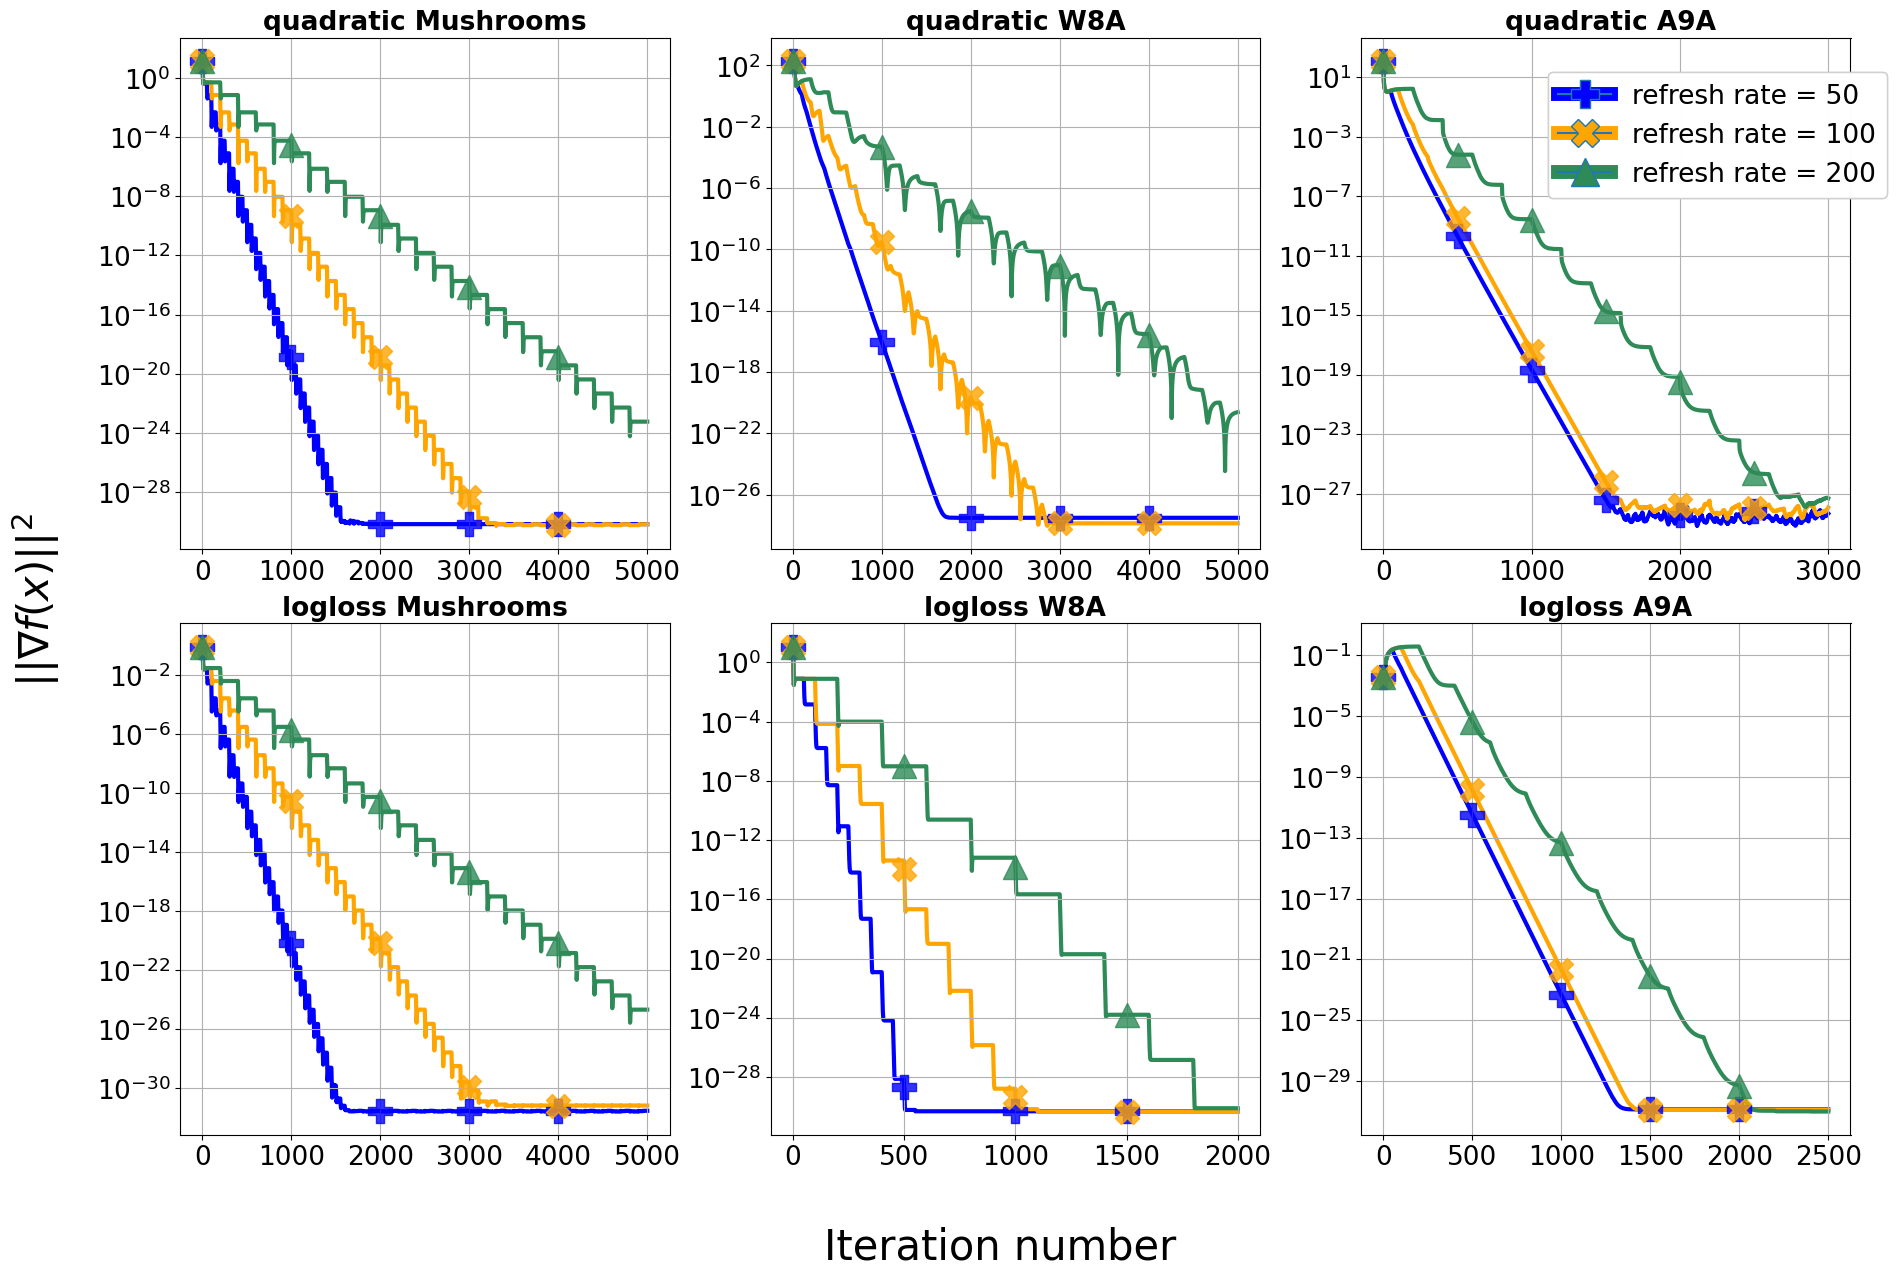

In [363]:
plotter = SixPlotter(legendNames = [dataNames[0], dataNames[1], dataNames[2], dataNames[3], dataNames[4], dataNames[5]], 
                       listOfListsOfLogs = [data[0], data[1], data[2], data[3], data[4], data[5]])
plotter.plot(stepLimiter = [5000, 5000, 3000, 5000, 2000, 2500], markersSteps = [1000, 1000, 500, 1000, 500, 500])

## ASEG

In [73]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SARAH/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [ ]:
start = time.time()
refreshRateList = [50, 100, 200]
for i in range(0,3):
    tmpLogs = []
    for j in range(len(refreshRateList)):
        solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 300, pRandomOracle = noRandom, logsGap = 1)
        tmpLogs.append(task.solve(solver = solver))
    saveManagerList[i].saveToCSV(refreshRateList, tmpLogs)

In [ ]:
refreshRateList = [50, 200, 500]

tmpLogs = []
for j in range(len(refreshRateList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[3], outerIterations = 300, pRandomOracle = noRandom, logsGap = 1)
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[3].saveToCSV(refreshRateList, tmpLogs)

In [79]:
refreshRateList = [200, 500]

tmpLogs = []
for j in range(len(refreshRateList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[4], outerIterations = 5000, pRandomOracle = noRandom, logsGap = 1)
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[4].saveToCSV(refreshRateList, tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
300 ASEG iterations complete
320 ASEG iterations complete
340 ASEG iterations complete
360 ASEG iterations complete
380 ASEG iterations complete
400 ASEG iterations complete
420 ASEG iterations complete
440 ASEG iterations complete
460 ASEG iterations complete
480 ASEG iterations complete
500 ASEG iterations complete
520 ASEG iterations complete
540 ASEG iterations complete
560 ASEG iterations complete
580 ASEG iterations complete
600 ASEG iterations complete
620 ASEG iterations complete
640 ASEG iterations complete
660 ASEG iterations complete
680 ASEG iterations 

In [98]:
refreshRateList = [50]

tmpLogs = []
for j in range(len(refreshRateList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[4], outerIterations = 5000, pRandomOracle = noRandom, logsGap = 1)
    tmpLogs.append(task.solve(solver = solver))

saveManagerList[4].addToCSV(["50"], tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
300 ASEG iterations complete
320 ASEG iterations complete
340 ASEG iterations complete
360 ASEG iterations complete
380 ASEG iterations complete
400 ASEG iterations complete
420 ASEG iterations complete
440 ASEG iterations complete
460 ASEG iterations complete
480 ASEG iterations complete
500 ASEG iterations complete
520 ASEG iterations complete
540 ASEG iterations complete
560 ASEG iterations complete
580 ASEG iterations complete
600 ASEG iterations complete
620 ASEG iterations complete
640 ASEG iterations complete
660 ASEG iterations complete
680 ASEG iterations 

In [97]:
saveManagerList[4].addToCSV(["keck"],[[1, 2, 3, 4]])

In [ ]:
refreshRateList = [50, 200, 500]

tmpLogs = []
for j in range(len(refreshRateList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[5], outerIterations = 300, pRandomOracle = noRandom, logsGap = 1)
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[5].saveToCSV(refreshRateList, tmpLogs)

In [ ]:
print( (time.time() - start)/60,"mins passed")

### Отрисовка

In [364]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SARAH/quadratic")
saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [365]:
data = []
dataNames = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])
    dataNames.append(manager.getLogsFromCSV()[0])

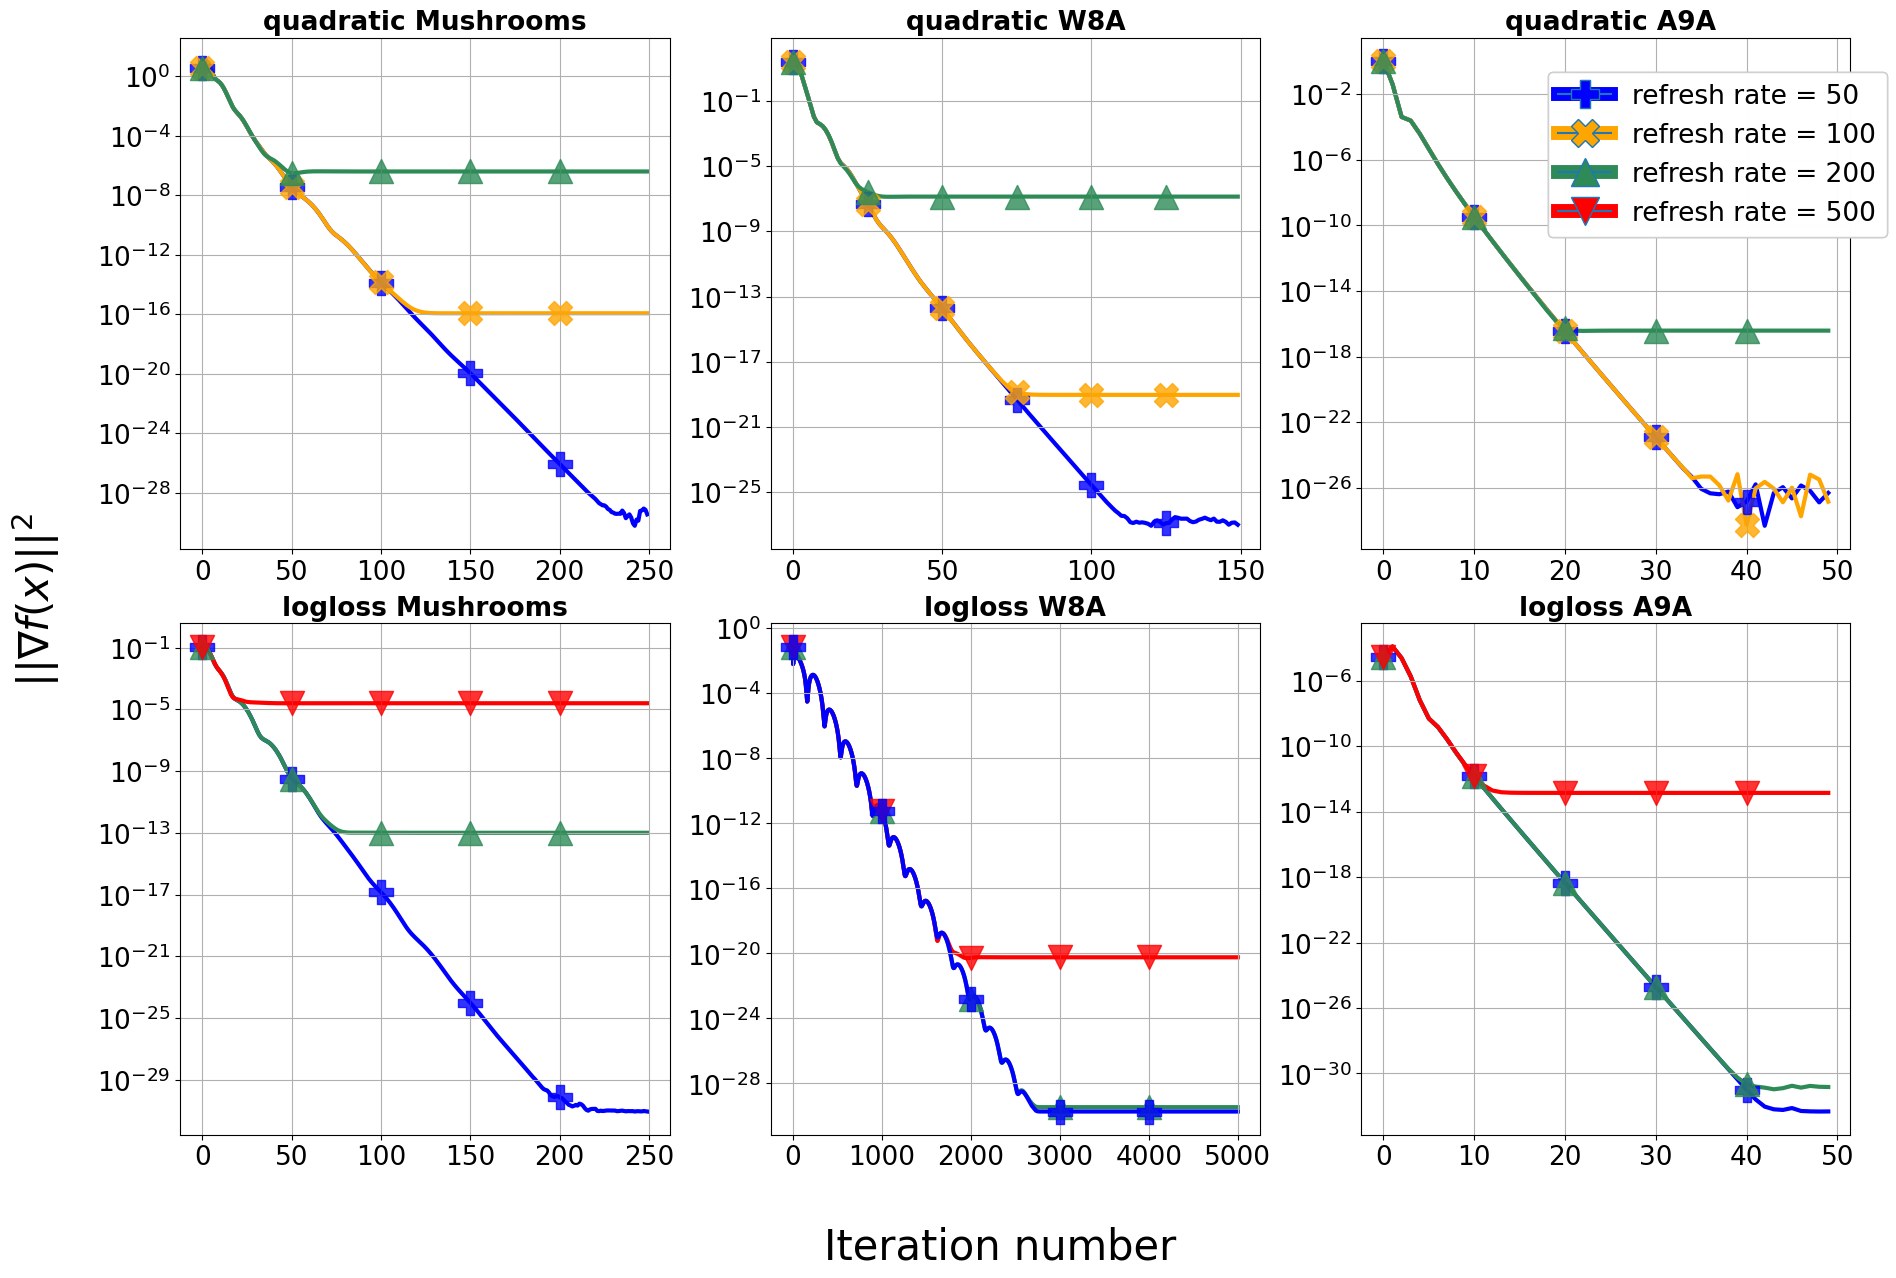

In [366]:
plotter = SixPlotter(legendNames = [dataNames[0], dataNames[1], dataNames[2], dataNames[3], dataNames[4], dataNames[5]], 
                       listOfListsOfLogs = [data[0], data[1], data[2], data[3], data[4], data[5]])
plotter.plot(stepLimiter = [250, 150, 50, 250, 10000, 50], markersSteps = [50, 25, 10, 50, 1000, 10])

## Stability 200

In [107]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [100]:
randomOraclesNames = ["percent = 1", "percent = 3", "percent = 5"]
randomOraclesList = [UniformRandomOracle(center = 1, percent = 1),
                     UniformRandomOracle(center = 1, percent = 3),
                     UniformRandomOracle(center = 1, percent = 5)]

In [129]:
start = time.time()
for i in range(len(pqrList)):
    tmpLogs = []
    for j in range(len(randomOraclesList)):
        solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 200, returnMod = Mean10PointMod(), collectLogs = False)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 300, pRandomOracle = randomOraclesList[j])
        tmpLogs.append(task.solve(solver = solver))
    saveManagerList[i].saveToCSV(randomOraclesNames, tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100

In [101]:
tmpLogs = []
for j in range(len(randomOraclesList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 200, returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[4], outerIterations = 5000, pRandomOracle = randomOraclesList[j])
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[4].saveToCSV(randomOraclesNames, tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
300 ASEG iterations complete
320 ASEG iterations complete
340 ASEG iterations complete
360 ASEG iterations complete
380 ASEG iterations complete
400 ASEG iterations complete
420 ASEG iterations complete
440 ASEG iterations complete
460 ASEG iterations complete
480 ASEG iterations complete
500 ASEG iterations complete
520 ASEG iterations complete
540 ASEG iterations complete
560 ASEG iterations complete
580 ASEG iterations complete
600 ASEG iterations complete
620 ASEG iterations complete
640 ASEG iterations complete
660 ASEG iterations complete
680 ASEG iterations 

### Отрисовка

In [367]:
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SARAH/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SARAH/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [368]:
data = []
dataNames = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])
    dataNames.append(manager.getLogsFromCSV()[0])

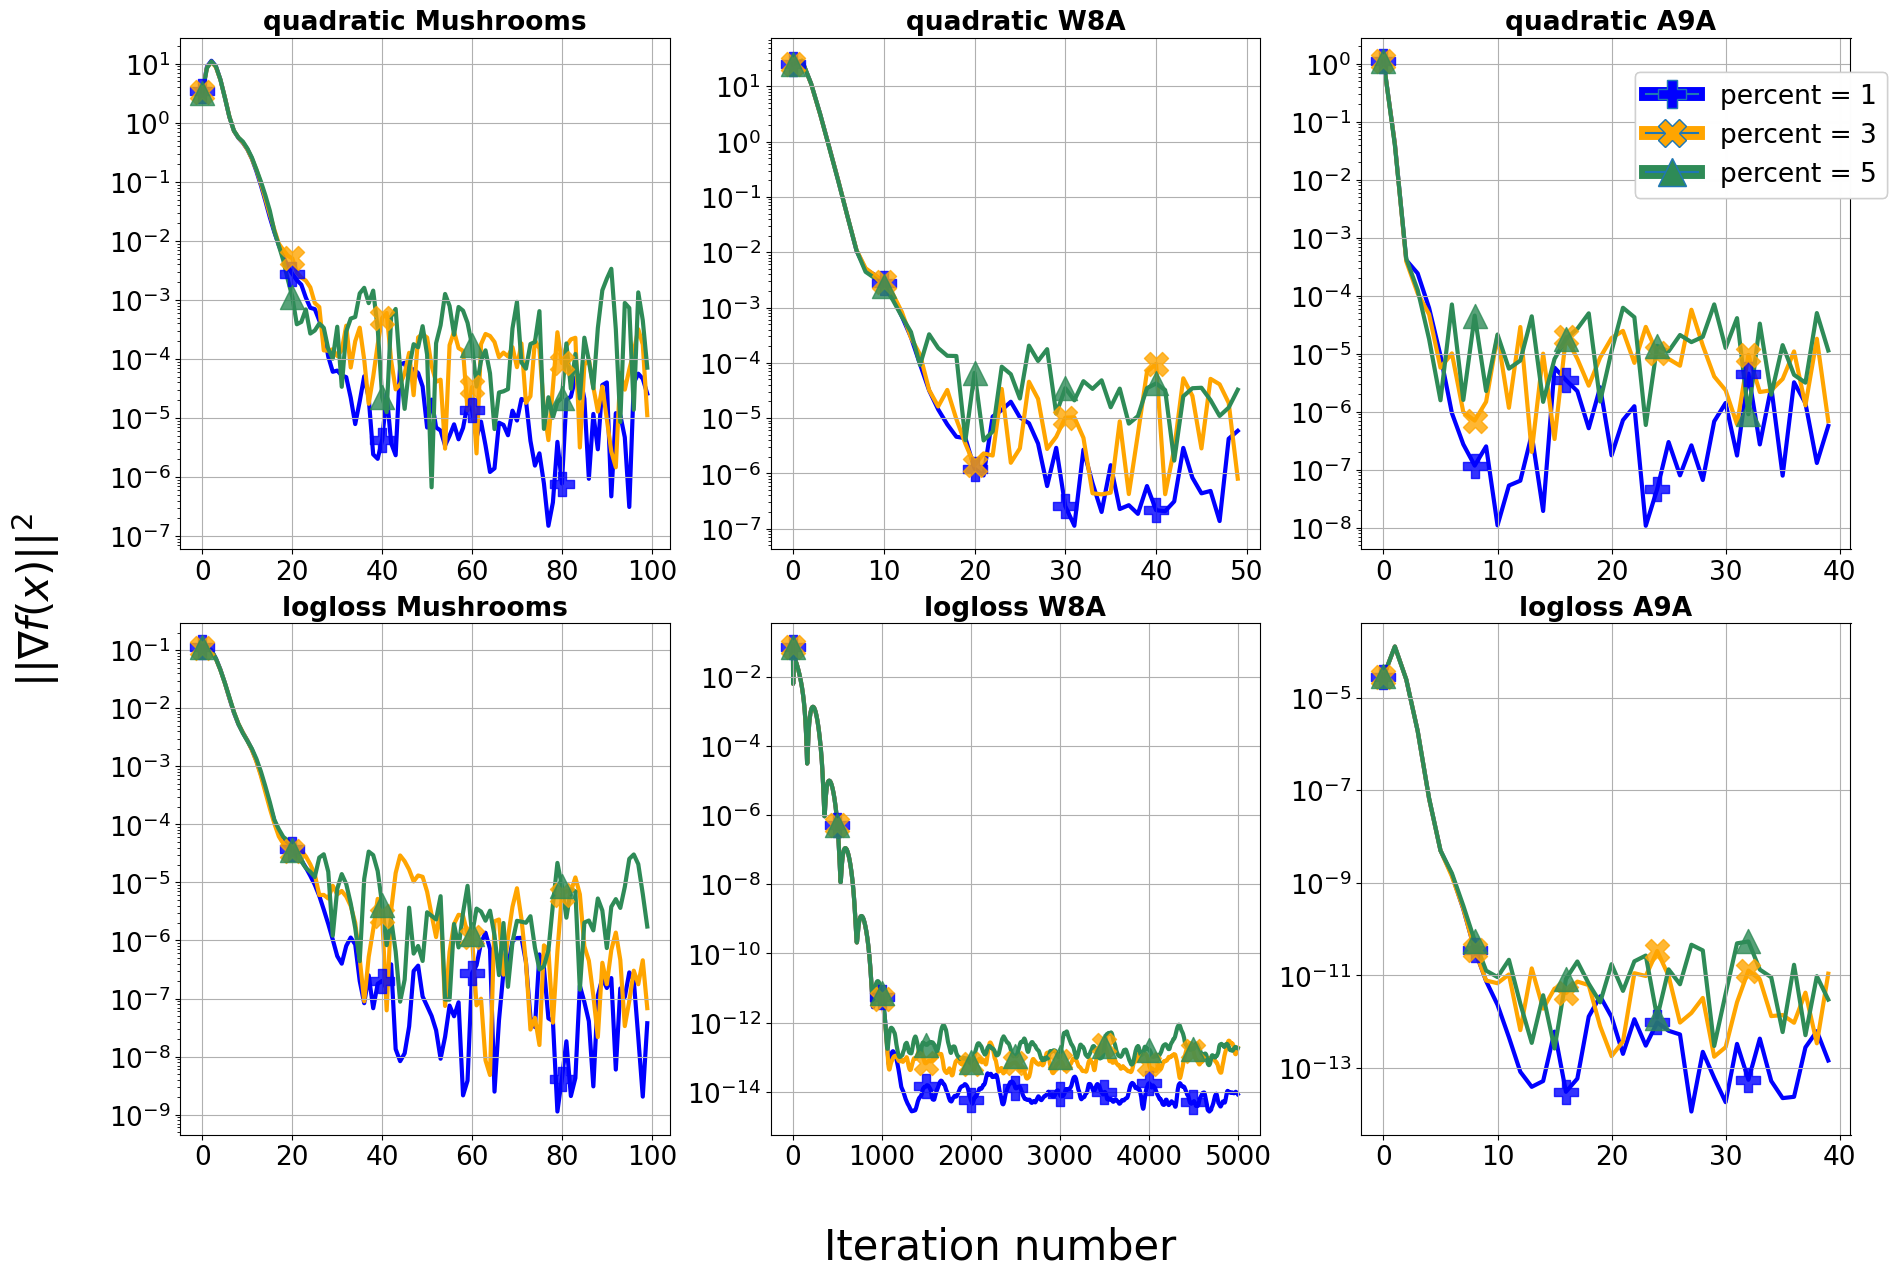

In [369]:
plotter = SixPlotter(legendNames = [dataNames[0], dataNames[1], dataNames[2], dataNames[3], dataNames[4], dataNames[5]], 
                       listOfListsOfLogs = [data[0], data[1], data[2], data[3], data[4], data[5]], graphType = 'stability')
plotter.plot(stepLimiter = [100, 50, 40, 100, -1, 40], legendWord = "{}", markersSteps = [20, 10, 8, 20, 500, 8])

# Тесты SVRG

## subtask

In [ ]:
saveManagerMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SVRG/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SVRG/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SVRG/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SVRG/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [97]:
start = time.time()
refreshRateList = [50, 100, 200]
for i in range(len(pqrList)):
    tmpLogs = []
    for j in range(len(refreshRateList)):
        solver = SVRGSolver(iterations = 8000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = LastPointMod(), collectLogs = True)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 1, pRandomOracle = noRandom, logsGap = 10)
        tmpLogs.append(task.subtaskSolve(solver = solver))
    saveManagerList[i].saveToCSV(refreshRateList, tmpLogs)

0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete
0 ASEG iterations complete


In [98]:
print( (time.time() - start)/60,"mins passed")

54.07467361688614 mins passed


### Отрисовка

In [76]:
saveManagerMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SVRG/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SVRG/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SVRG/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-subtask.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-subtask.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-subtask.csv", directory = "experiments/SVRG/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [77]:
data = []
dataNames = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])
    dataNames.append(manager.getLogsFromCSV()[0])

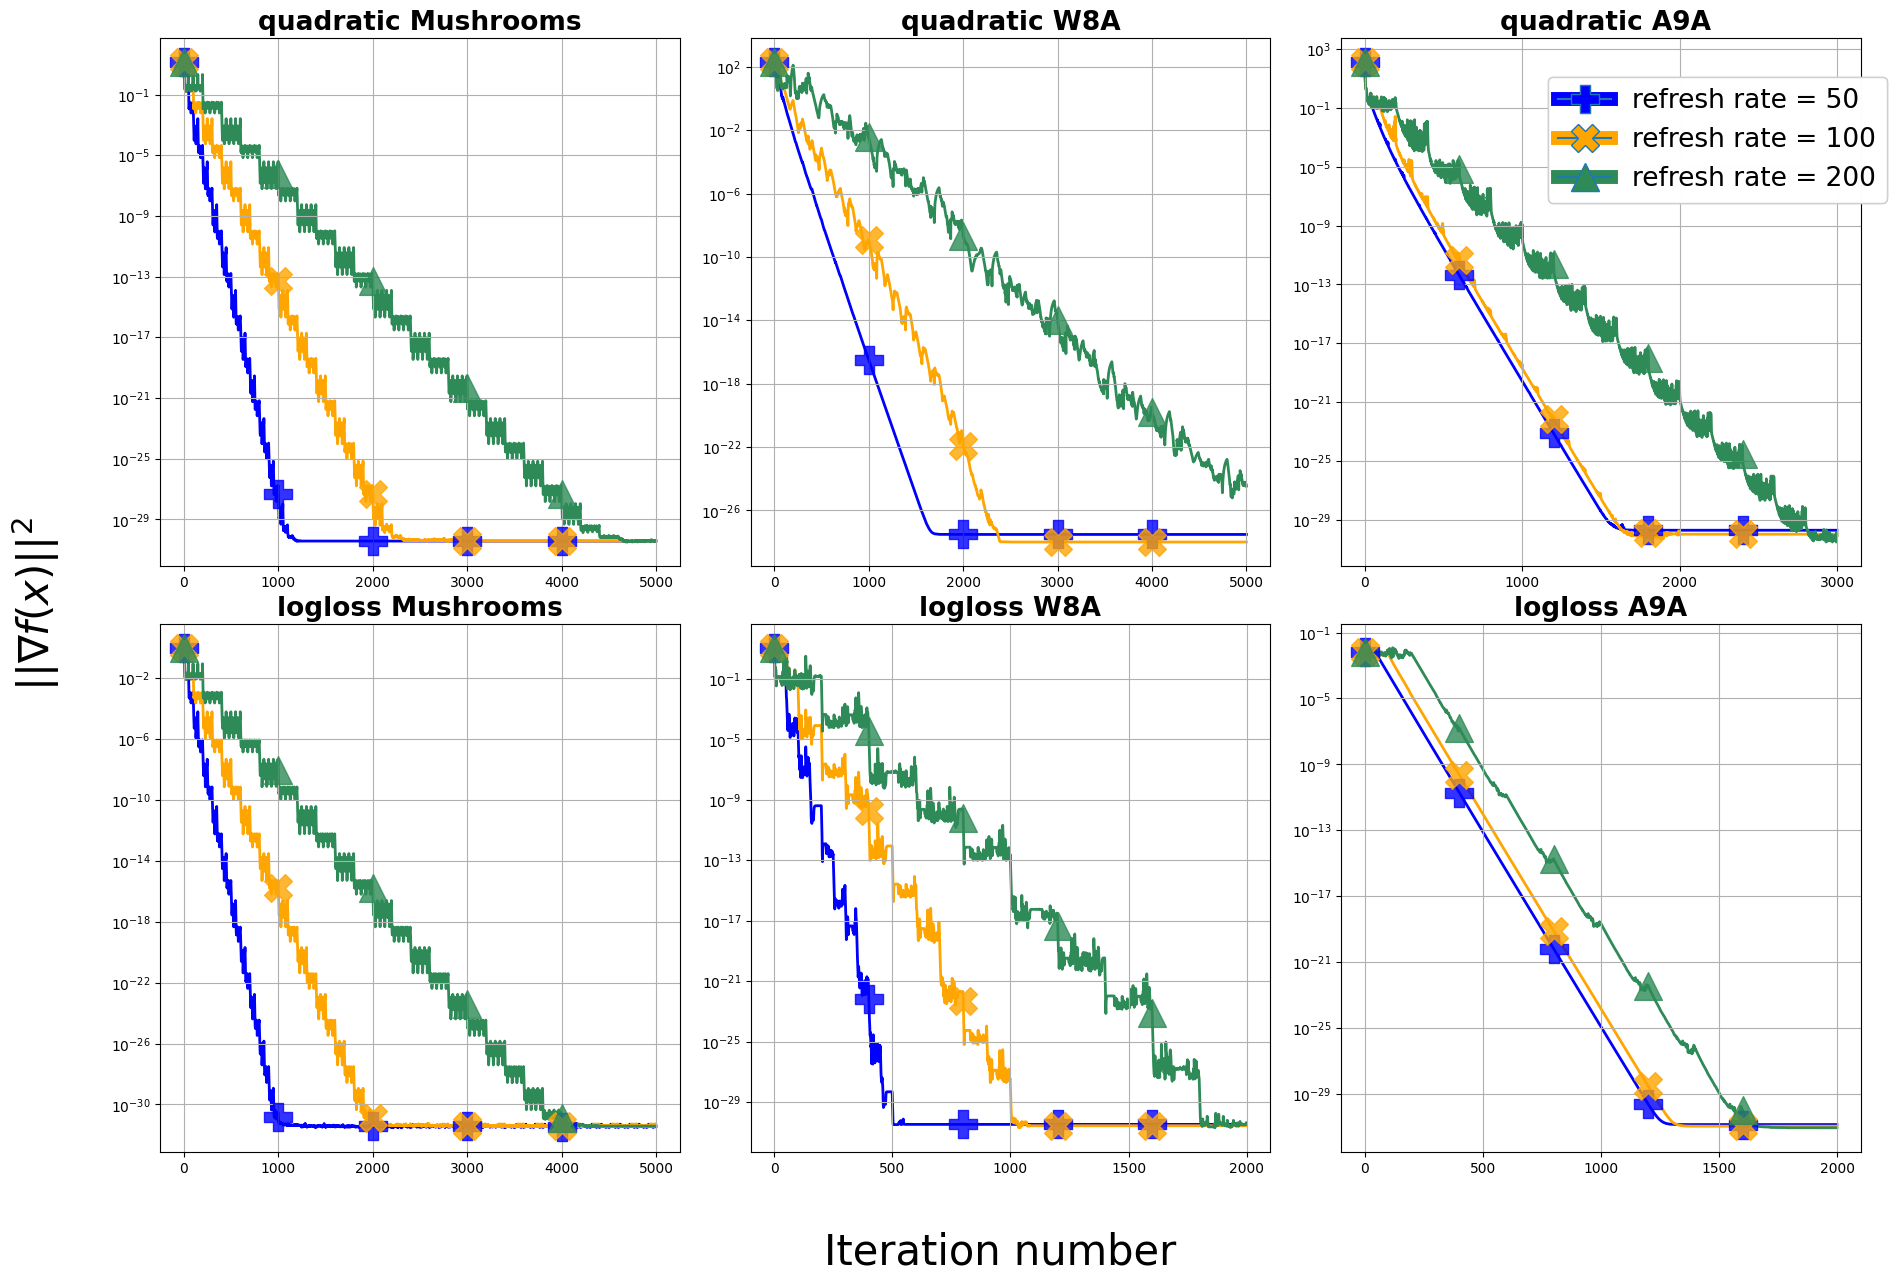

In [78]:
plotter = SixPlotter(legendNames = [dataNames[0], dataNames[1], dataNames[2], dataNames[3], dataNames[4], dataNames[5]], 
                       listOfListsOfLogs = [data[0], data[1], data[2], data[3], data[4], data[5]])
plotter.plot(stepLimiter = [5000, 5000, 3000, 5000, 2000, 2000], markersSteps = [1000, 1000, 600, 1000, 400, 400])

## ASEG

In [74]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SVRG/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SVRG/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SVRG/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SVRG/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [113]:
start = time.time()
refreshRateList = [50, 100, 200]
for i in range(3):
    tmpLogs = []
    for j in range(len(refreshRateList)):
        solver = SVRGSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 300, pRandomOracle = noRandom, logsGap = 1)
        tmpLogs.append(task.solve(solver = solver))
    saveManagerList[i].saveToCSV(refreshRateList, tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100

In [79]:
refreshRateList = [50, 200, 500]
tmpLogs = []
for j in range(1, len(refreshRateList)):
    solver = SVRGSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[4], outerIterations = 5000, pRandomOracle = noRandom, logsGap = 1)
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[4].saveToCSV(refreshRateList, tmpLogs)

0 ASEG iterations complete
20 ASEG iterations complete
40 ASEG iterations complete
60 ASEG iterations complete
80 ASEG iterations complete
100 ASEG iterations complete
120 ASEG iterations complete
140 ASEG iterations complete
160 ASEG iterations complete
180 ASEG iterations complete
200 ASEG iterations complete
220 ASEG iterations complete
240 ASEG iterations complete
260 ASEG iterations complete
280 ASEG iterations complete
300 ASEG iterations complete
320 ASEG iterations complete
340 ASEG iterations complete
360 ASEG iterations complete
380 ASEG iterations complete
400 ASEG iterations complete
420 ASEG iterations complete
440 ASEG iterations complete


KeyboardInterrupt: 

In [ ]:
start = time.time()
refreshRateList = [50, 200, 500]
for i in range(4, len(pqrList)):
    tmpLogs = []
    for j in range(len(refreshRateList)):
        solver = SVRGSolver(iterations = 2000, step = classicStep(), refreshRate = refreshRateList[j], returnMod = Mean10PointMod(), collectLogs = False)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 300, pRandomOracle = noRandom, logsGap = 1)
        tmpLogs.append(task.solve(solver = solver))
    saveManagerList[i].saveToCSV(refreshRateList, tmpLogs)

### Отрисовка 

In [385]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SVRG/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SVRG/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SVRG/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG.csv", directory = "experiments/SVRG/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [386]:
data = []
dataNames = []
for manager in saveManagerList:
    data.append(manager.getLogsFromCSV()[1])
    dataNames.append(manager.getLogsFromCSV()[0])

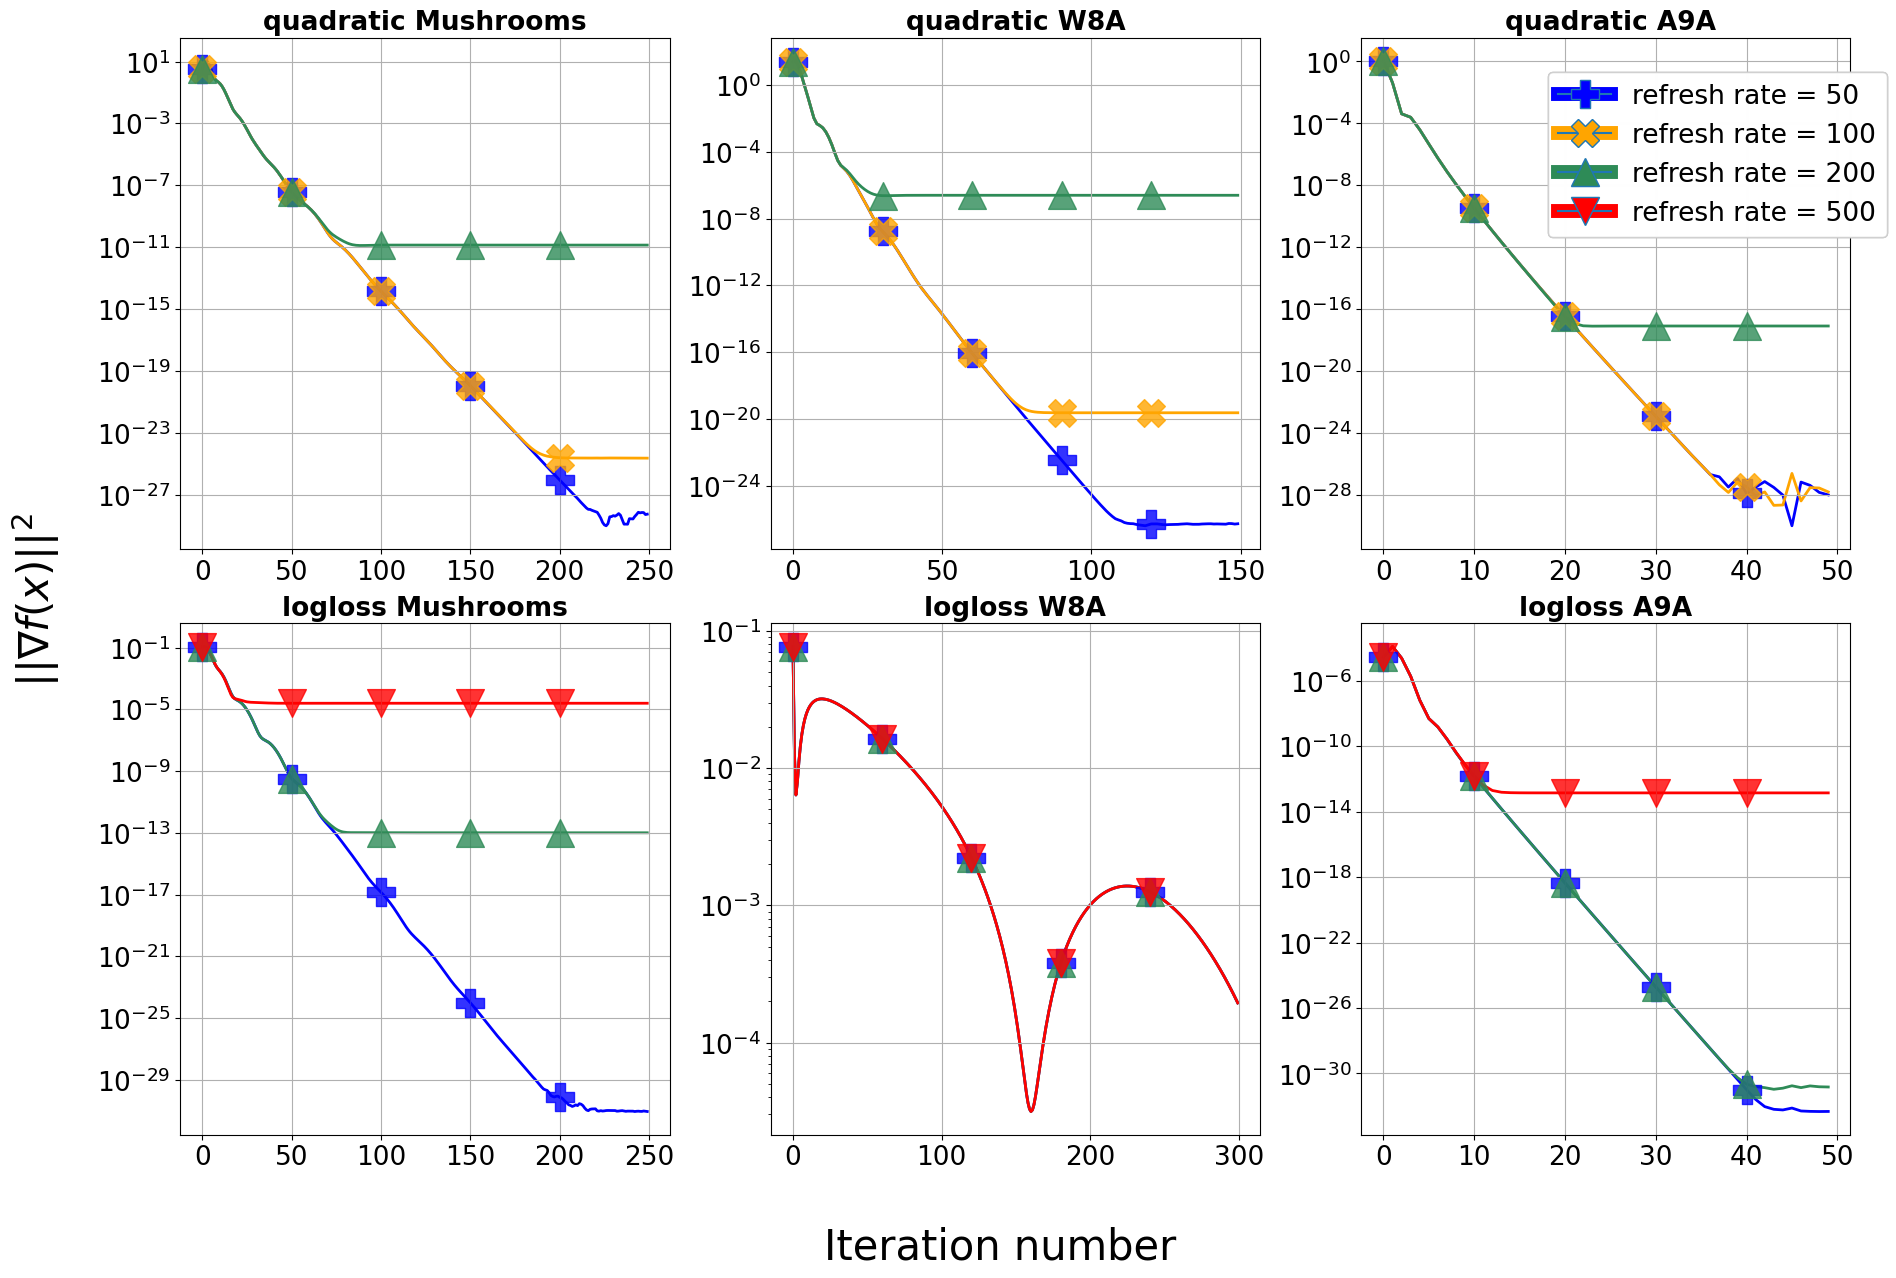

In [387]:
plotter = SixPlotter(legendNames = [dataNames[0], dataNames[1], dataNames[2], dataNames[3], dataNames[4], dataNames[5]], 
                       listOfListsOfLogs = [data[0], data[1], data[2], data[3], data[4], data[5]])
plotter.plot(stepLimiter = [250, 150, 50, 250, 300, 50], markersSteps = [50, 30, 10, 50, 60, 10])

## Stability 200

In [ ]:
#Менеджеры для сохранения и выгрузки файлов
saveManagerMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SVRG/quadratic")
saveManagerW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SVRG/quadratic")
saveManagerA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SVRG/quadratic")

saveManagerLoglossMushrooms = CSVManager(fileName = "mushrooms-ASEG-stability-200.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossW8A = CSVManager(fileName = "w8a-ASEG-stability-200.csv", directory = "experiments/SVRG/logloss")
saveManagerLoglossA9A = CSVManager(fileName = "a9a-ASEG-stability-200.csv", directory = "experiments/SVRG/logloss")

saveManagerList = [saveManagerMushrooms, saveManagerW8A, saveManagerA9A,
                  saveManagerLoglossMushrooms, saveManagerLoglossW8A, saveManagerLoglossA9A]

In [ ]:
randomOraclesNames = ["percent = 1", "percent = 3", "percent = 5"]
randomOraclesList = [UniformRandomOracle(center = 1, percent = 1),
                     UniformRandomOracle(center = 1, percent = 3),
                     UniformRandomOracle(center = 1, percent = 5)]

In [ ]:
start = time.time()
for i in range(len(pqrList)):
    tmpLogs = []
    for j in range(len(randomOraclesList)):
        solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 200, returnMod = Mean10PointMod(), collectLogs = False)
        task = Accelerated_Extragradient(pqr = pqrList[i], outerIterations = 300, pRandomOracle = randomOraclesList[j])
        tmpLogs.append(task.solve(solver = solver))
    saveManagerList[i].saveToCSV(randomOraclesNames, tmpLogs)

In [ ]:
tmpLogs = []
for j in range(len(randomOraclesList)):
    solver = SARAHSolver(iterations = 2000, step = classicStep(), refreshRate = 200, returnMod = Mean10PointMod(), collectLogs = False)
    task = Accelerated_Extragradient(pqr = pqrList[4], outerIterations = 5000, pRandomOracle = randomOraclesList[j])
    tmpLogs.append(task.solve(solver = solver))
saveManagerList[4].saveToCSV(randomOraclesNames, tmpLogs)

### Отрисовка